# set up

In [55]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from safetensors.torch import save_model, load_model, load_file, safe_open

# TransformerWithHead inherets PreTrainedModel class: https://huggingface.co/docs/transformers/v4.40.1/en/main_classes/model#transformers.PreTrainedModel
# takes a vector of token ids as input, instead of a dict of {'input_ids': [], 'attention_mask': []} as with the AutoModel class
from weak_to_strong.model import TransformerWithHead

In [2]:
import sys
sys.path.insert(0, '../repmap')

from util import *

In [3]:
print(f'available devices: {torch.cuda.device_count()}')
print(f'current device: {torch.cuda.current_device()}')
print(f'device name: {torch.cuda.get_device_name()}')

available devices: 1
current device: 0
device name: NVIDIA A100 80GB PCIe


In [4]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using: " + str(device))

using: cuda


# load models

In [4]:
# # load state_dict alone

# state_dict = load_file("../results/default/bs=32-dn=amaz_pola-e=2-ee=1000000-lp=0-l=xent-l=5e-05-ls=cosi_anne-mc=1024-ms=gpt2-nd=20000-ntd=10000-o=adam-s=0-twd=0/model.safetensors")

# state_dict['lm.transformer.h.1.attn.c_attn.weight']

In [5]:
# create pre-ft model

model_pre = TransformerWithHead.from_pretrained('gpt2').to(device)
# model_pre

In [6]:
# create post-ft model + load in state dict

model_post = TransformerWithHead.from_pretrained('gpt2').to(device)

load_model(model=model_post, filename="../results/default/bs=32-dn=amaz_pola-e=2-ee=1000000-lp=0-l=xent-l=5e-05-ls=cosi_anne-mc=1024-ms=gpt2-nd=20000-ntd=10000-o=adam-s=0-twd=0/model.safetensors")

model_post = model_post.to(device)
# model_post

In [5]:
# create pre-ft strong model

model_strong_pre = TransformerWithHead.from_pretrained('gpt2-xl').to(device)
# model_strong_pre

In [7]:
# create post-ft strong model + load in state dict

model_strong_post = TransformerWithHead.from_pretrained('gpt2-xl').to(device)

load_model(model=model_strong_post, filename="../results/default/bs=32-dn=amaz_pola-e=2-ee=1000000-lp=0-l=xent-l=1e-05-ls=cosi_anne-mc=1024-ms=gpt2-xl-nd=20000-ntd=10000-o=adam-s=0-twd=0/model-00001-of-00002.safetensors", strict=False)
load_model(model=model_strong_post, filename="../results/default/bs=32-dn=amaz_pola-e=2-ee=1000000-lp=0-l=xent-l=1e-05-ls=cosi_anne-mc=1024-ms=gpt2-xl-nd=20000-ntd=10000-o=adam-s=0-twd=0/model-00002-of-00002.safetensors", strict=False)

model_strong_post = model_strong_post.to(device)
# model_strong_post

# extract internal reps

## input processing

In [8]:
# input processing

def text2id(tokenizer, text):
    
    """ 
    tokenize input text and convert to input ids 
    - tokenizer: AutoTokenizer. pad_token required: tokenizer.pad_token = tokenizer.eos_token
    - text: size (B,) = (batch size,). each element is an input text string, e.g., ['test blah', 'blah blah']
    returns:
    - sentences: dict {'input_ids': [], 'attention_mask': []}. each value has shape (B, L): (batch_size, num token in sentence).
    """

    # tokens = tokenizer.tokenize(text)
    # input_ids = tokenizer.convert_tokens_to_ids(tokens)
    # input_ids = torch.tensor([input_ids]).to(device)
    # return input_ids

    # sentences is a dict of {'input_ids': [], 'attention_mask': []}
    sentences = tokenizer(
            text,
            return_tensors='pt',  # pt = pytorch style tensor
            padding=True
        ).to(device)
    
    return sentences

In [8]:
# sanity check

tokenizer_gpt2 = AutoTokenizer.from_pretrained('gpt2')
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

text = [
    "This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^", 
    "blah blah blahblah!"
]


ss = text2id(tokenizer_gpt2, text)
ss

{'input_ids': tensor([[ 1212,  2128,  2610,   373,  4950,     0,   632, 32281,   262,   264,
         24156,   287,   534,  2000,   523,   880,   314,   561,   664,   296,
           437,   340,   772,   284,   661,   508,  5465,   410,   312,    13,
           983,  2647,     0,   314,   423,  2826,   262,   983,  8750,    78,
          6372,   475,   503,   286,   477,   286,   262,  1830,   314,   423,
          1683,  2826,   340,   468,   262,  1266,  2647,     0,   632, 12983,
          1497,   422, 14897, 10586,   278,   290,  2753,   257, 34093,   372,
          2239,   351, 48612, 32497,   290,  5848,   913, 28127,   292,    13,
           632,   561, 14947,  2687,   508, 16609,   284,  6004,     0, 10563,
            62,    61],
        [ 2436,   993, 33367, 33367,  2436,   993,     0, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256

In [9]:
# sanity check

tokenizer_gpt2xl = AutoTokenizer.from_pretrained('gpt2-xl')
tokenizer_gpt2xl.pad_token = tokenizer_gpt2xl.eos_token

text = [
    "This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^", 
    "blah blah blahblah!"
]


ss = text2id(tokenizer_gpt2xl, text)
ss

{'input_ids': tensor([[ 1212,  2128,  2610,   373,  4950,     0,   632, 32281,   262,   264,
         24156,   287,   534,  2000,   523,   880,   314,   561,   664,   296,
           437,   340,   772,   284,   661,   508,  5465,   410,   312,    13,
           983,  2647,     0,   314,   423,  2826,   262,   983,  8750,    78,
          6372,   475,   503,   286,   477,   286,   262,  1830,   314,   423,
          1683,  2826,   340,   468,   262,  1266,  2647,     0,   632, 12983,
          1497,   422, 14897, 10586,   278,   290,  2753,   257, 34093,   372,
          2239,   351, 48612, 32497,   290,  5848,   913, 28127,   292,    13,
           632,   561, 14947,  2687,   508, 16609,   284,  6004,     0, 10563,
            62,    61],
        [ 2436,   993, 33367, 33367,  2436,   993,     0, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256

## rep extraction

In [10]:
# hook: https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/#method-3-attach-a-hook
# register_forward_hook: https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook


# helper func
def get_activation(module_name, activations):

    """
    helper function for creating forward hooks.
    - module_name: name of module to register the hook onto & extract reps from.
    - activations: dict variable for the created hook to store extracted reps.
    """

    def hook(model, input, output):
        activations[module_name] = output[0].detach().to(device)  # 'output' is a tuple
    
    return hook


def extract_hidden_states(model, input_ids):

    """
    extract model internal reps with given inputs.
    - model: TransformerWithHead (inherets PreTrainedModel).
    - input_ids: shape (B, L): (batch_size, num token in sentence). use sentences['input_ids'] from text2id().
    returns:
    - activations: dict {layer name: activation}. each layer's activation has shape (B, L, D): (batch_size, num token in sentence, model dim)
    """

    # stores extracted model reps
    activations = {}  
    
    # register hooks on layers of choice
    hooks = []
    for name, module in model.transformer.named_modules():

        # set modules to register hooks on
        if isinstance(module, torch.nn.modules.Module):
            h = module.register_forward_hook(get_activation(name, activations))
            hooks.append(h)
    
    # pass input_ids through model for auto-extraction through hooks
    input_ids = input_ids.to(device)
    model.eval()
    with torch.no_grad():
        _ = model(input_ids)

    # detach hooks after use
    for h in hooks:
        h.remove()

    return activations

In [33]:
# sanity check
model_strong_pre(ss['input_ids'])

tensor([[0., 0.],
        [0., 0.]], device='cuda:0', grad_fn=<MmBackward0>)

In [13]:
# sanity check
activations = extract_hidden_states(model=model_strong_post, input_ids=ss['input_ids'])  # dict: {layer name: activation}
activations['h.11'].shape

torch.Size([2, 92, 1600])

## dataset & dataloader

In [16]:
# load huggingface datasets (train+test)

datasets = load_dataset("amazon_polarity").with_format("torch", device=device)
# datasets = datasets.shuffle(seed=42, buffer_size=10_000)  # shuffles the shards order + uses a shuffle buffer
datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

In [19]:
# create dataloaders from datasets
# use huggingface datasets with dataloader: https://huggingface.co/docs/datasets/en/loading

# set how many samples to use for train and test
N = {'train': 1000, 'test': len(datasets['test'])} 
print(N)

dataloaders = collections.defaultdict()
for split in datasets.keys():
    dataloaders[split] = DataLoader(
        Subset(datasets[split], list(range(N[split]))),
        # datasets[split].with_format("torch"),
        batch_size=10, 
        # sampler=SubsetRandomSampler(list(range(N[split]))),
        shuffle=False
    )

{'train': 1000, 'test': 400000}


In [20]:
# sanity check

next(iter(dataloaders['train']))
# next(iter(dataloaders['test']))

{'label': tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0'),
 'title': ['Stuning even for the non-gamer',
  'The best soundtrack ever to anything.',
  'Amazing!',
  'Excellent Soundtrack',
  'Remember, Pull Your Jaw Off The Floor After Hearing it',
  'an absolute masterpiece',
  'Buyer beware',
  'Glorious story',
  'A FIVE STAR BOOK',
  'Whispers of the Wicked Saints'],
 'content': ['This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
  "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music 

## main process

In [21]:
# helper func for pooling
def pooling(activations:dict, layer_name:str, attention_mask:torch.Tensor, method:str):

    # get unpooled activation from target layer
    activation_unpooled = activations[layer_name]  # (B, L, D): (batch_size, num token in sentence, model dim)
    

    # get pooled activation across tokens for each sentence
    if method == 'first':
        activation_pooled = activation_unpooled[:, 0, :]   # (B, D)

    elif method == 'last':
        activation_pooled = activation_unpooled[range(activation_unpooled.shape[0]), attention_mask.sum(dim=1) - 1, :]   # (B, D)

    elif method == 'mean':
        # mask padding tokens (where attention_mask is 0) with nan
        activation_unpooled_masked = activation_unpooled.masked_fill(
            attention_mask.unsqueeze(-1)==0,
            float('nan')
        )
        # max-pooling across tokens (L dimension) in each sentence
        activation_pooled = activation_unpooled_masked.nanmean(dim=1)   # (B, D)

    elif method == 'max':
        # mask padding tokens (where attention_mask is 0) with -inf
        activation_unpooled_masked = activation_unpooled.masked_fill(
            attention_mask.unsqueeze(-1)==0,
            float('-inf')
        )
        # max-pooling across tokens (L dimension) in each sentence
        activation_pooled, _ = activation_unpooled_masked.max(dim=1)   # (B, D)

    return activation_pooled  # (B, D): (batch_size, model dim)

In [22]:
# main extration process: get reps from chosen layers, pooling, append to be saved

def text2rep(dataloader, tokenizer, model, layer_names:list):

    """
    layer_names: a list of layers to extract activation from. e.g., ['h.10', 'h.11']
    """

    # iter through mini-batches in dataloader once to extract activation for all obs
    activations_all = collections.defaultdict(torch.Tensor)
    for batch in tqdm(dataloader):
        
        # convert text to input_ids + attention_mask
        sentences = text2id(tokenizer, batch['content'])  # dict: {input_ids: token ids, attention_mask: has token or padding}

        # extract activation from each layer
        activations = extract_hidden_states(
            model=model, 
            input_ids=sentences['input_ids']
        )  # dict: {layer name: activation}

        # keep activations from chosen layers + pooling
        for layer_name in layer_names:

            # get pooled activation
            activation_pooled = pooling(
                activations=activations, 
                layer_name=layer_name, 
                attention_mask=sentences['attention_mask'], 
                method='mean'
            )  # (B, D): (batch_size, model dim)
            
            # append
            activations_all[layer_name] = torch.cat(
                (activations_all[layer_name].to(device), activation_pooled), 
                dim=0
            )

    return activations_all

In [62]:
# example

gpt2_post = text2rep(
    dataloader=dataloaders['train'], 
    tokenizer=tokenizer_gpt2, 
    model=model_post, 
    layer_names=['h.10', 'h.11']
)

print(gpt2_post['h.10'].shape)
print(gpt2_post['h.10'])
print(gpt2_post['h.11'].shape)
print(gpt2_post['h.11'])

100%|██████████| 100/100 [00:03<00:00, 30.42it/s]

torch.Size([1000, 768])
tensor([[ 4.8404,  3.2834, -1.9144,  ..., -0.3921, -4.5961, -2.0894],
        [-3.3382,  1.8766, -1.7150,  ..., -2.1792,  0.0200, -0.2466],
        [-0.1736,  7.8676,  1.4048,  ..., -2.2731,  3.2617,  0.6957],
        ...,
        [ 3.0989,  7.2682,  1.5880,  ...,  0.6372,  1.3751,  2.3761],
        [ 0.2162,  7.8918, -2.6932,  ..., -1.6321,  2.0773,  1.9474],
        [ 0.6968,  7.0811,  2.0809,  ..., -2.0227,  2.1725,  1.4960]],
       device='cuda:0')
torch.Size([1000, 768])
tensor([[ 6.2053e+00,  7.5723e+00, -8.6395e+00,  ..., -3.7627e+00,
         -4.6410e+00, -8.0845e+00],
        [-5.0004e+00,  3.2120e+00, -2.7914e+00,  ...,  1.4626e+00,
          1.3013e+00, -2.1181e+00],
        [-1.2901e+00,  1.2382e+01,  5.4619e-01,  ..., -5.8366e-02,
          6.0298e+00, -1.5424e+00],
        ...,
        [ 2.8257e+00,  1.1173e+01, -1.1255e-02,  ...,  6.9910e+00,
          5.0105e+00, -6.7164e-02],
        [ 1.7586e+00,  1.0032e+01, -8.5106e+00,  ...,  1.5049e+00,
  

In [64]:
gpt2_pre = text2rep(
    dataloader=dataloaders['train'], 
    tokenizer=tokenizer_gpt2, 
    model=model_pre, 
    layer_names=['h.10', 'h.11']
)

print(gpt2_pre['h.10'].shape)
print(gpt2_pre['h.10'])
print(gpt2_pre['h.11'].shape)
print(gpt2_pre['h.11'])

100%|██████████| 100/100 [00:03<00:00, 28.66it/s]

torch.Size([1000, 768])
tensor([[ 0.7964, -1.4488, -2.6808,  ...,  3.4165,  0.9731, -2.0792],
        [ 1.8860, -0.3864, -2.4782,  ..., -0.5510,  0.1220, -0.9070],
        [ 0.7193,  0.7334, -4.1835,  ...,  1.1297,  2.5225,  1.6981],
        ...,
        [ 1.2478,  0.1239, -1.8912,  ..., -0.9093,  0.4406, -1.1400],
        [ 0.5011, -0.7305,  0.0511,  ..., -2.8094,  3.0355, -2.0916],
        [ 2.0093, -1.2039, -3.6110,  ..., -0.8403,  2.1377,  0.0653]],
       device='cuda:0')
torch.Size([1000, 768])
tensor([[ 1.8162, -1.5948, -3.9047,  ...,  4.2885,  0.3454, -1.6128],
        [ 2.3710, -0.4046, -4.0925,  ..., -0.2042, -0.1911, -1.6371],
        [ 0.7923,  1.7717, -4.5742,  ...,  1.6722,  2.8459,  0.5418],
        ...,
        [ 1.8438, -0.0164, -2.0520,  ..., -0.3600,  0.7284, -1.4890],
        [ 0.1838, -0.0427,  0.3320,  ..., -3.4965,  4.0038, -2.7074],
        [ 1.9942, -0.8328, -3.9446,  ...,  0.8062,  3.1185, -1.6922]],
       device='cuda:0')


In [23]:
# example

gpt2xl_post = text2rep(
    dataloader=dataloaders['train'], 
    tokenizer=tokenizer_gpt2xl, 
    model=model_strong_post, 
    layer_names=['h.10', 'h.11']
)

print(gpt2xl_post['h.10'].shape)
print(gpt2xl_post['h.10'])
print(gpt2xl_post['h.11'].shape)
print(gpt2xl_post['h.11'])

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]

torch.Size([1000, 1600])
tensor([[-0.8024, -0.5057,  0.3613,  ..., -0.1777, -0.4208, -0.8483],
        [-0.7440, -1.0171,  0.3890,  ..., -0.3785, -0.5659, -1.1690],
        [-1.0563, -0.6489,  0.1251,  ..., -0.3856, -0.2560, -0.4969],
        ...,
        [-0.3937, -0.8671, -0.2776,  ..., -0.3974, -0.3338, -1.1325],
        [-0.4944, -0.3029,  0.2253,  ..., -0.2147, -0.6564, -0.7448],
        [-0.6177, -0.2051,  0.3568,  ..., -0.0432, -0.3263, -0.4903]],
       device='cuda:0')
torch.Size([1000, 1600])
tensor([[-0.8075, -0.5135,  0.4093,  ..., -0.1748, -0.4125, -0.8853],
        [-0.8233, -1.1235,  0.2957,  ..., -0.3343, -0.5583, -1.2670],
        [-1.1014, -0.6056,  0.1215,  ..., -0.3544, -0.2509, -0.4939],
        ...,
        [-0.4893, -0.9857, -0.2986,  ..., -0.3359, -0.3937, -1.3026],
        [-0.5869, -0.2662,  0.3563,  ..., -0.2949, -0.7308, -0.9189],
        [-0.6153, -0.1578,  0.3770,  ..., -0.0882, -0.3082, -0.5232]],
       device='cuda:0')


In [29]:
gpt2xl_pre = text2rep(
    dataloader=dataloaders['train'], 
    tokenizer=tokenizer_gpt2xl, 
    model=model_strong_pre, 
    layer_names=['h.10', 'h.11']
)

print(gpt2xl_pre['h.10'].shape)
print(gpt2xl_pre['h.10'])
print(gpt2xl_pre['h.11'].shape)
print(gpt2xl_pre['h.11'])

100%|██████████| 100/100 [00:39<00:00,  2.54it/s]

torch.Size([1000, 1600])
tensor([[-1.0794, -0.4727,  0.1244,  ..., -0.2131, -0.4812, -0.6352],
        [-1.0592, -1.0818,  0.1694,  ..., -0.3424, -0.6112, -1.0326],
        [-1.1896, -0.5917, -0.0984,  ..., -0.4256, -0.2763, -0.3416],
        ...,
        [-0.6294, -1.0298, -0.4120,  ..., -0.3650, -0.3353, -1.0919],
        [-0.8331, -0.2928,  0.0489,  ..., -0.3569, -0.6342, -0.6189],
        [-0.8783, -0.1870,  0.1416,  ..., -0.1247, -0.3869, -0.4302]],
       device='cuda:0')
torch.Size([1000, 1600])
tensor([[-1.1029, -0.4887,  0.1348,  ..., -0.2437, -0.4804, -0.6456],
        [-1.1359, -1.1447,  0.0276,  ..., -0.3153, -0.6042, -1.1109],
        [-1.2588, -0.5580, -0.1243,  ..., -0.4380, -0.2758, -0.3653],
        ...,
        [-0.7333, -1.1132, -0.4384,  ..., -0.3302, -0.3686, -1.2238],
        [-0.9096, -0.2417,  0.1045,  ..., -0.4676, -0.6845, -0.7316],
        [-0.8917, -0.1267,  0.1321,  ..., -0.1936, -0.3672, -0.4418]],
       device='cuda:0')


## save

In [ ]:
# db = {
#     'rep': gpt2xl_post,
#     'label': datasets['train']['label'][:N['train']]
# }

# with open(f"../results/reps/gpt2xl_ft=amazpola-gt_N={N['train']}.pickle", 'wb') as f:
#     pickle.dump(db, f)

In [24]:
with (open("../results/reps/gpt2xl_ft=amazpola-gt_N=10000.pickle", "rb")) as f:
    db = pickle.load(f)

db

{'rep': defaultdict(torch.Tensor,
             {'h.10': tensor([[-0.8024, -0.5057,  0.3613,  ..., -0.1777, -0.4208, -0.8483],
                      [-0.7440, -1.0171,  0.3890,  ..., -0.3785, -0.5659, -1.1690],
                      [-1.0563, -0.6489,  0.1251,  ..., -0.3856, -0.2560, -0.4969],
                      ...,
                      [-0.8785, -0.1644,  0.0956,  ..., -0.5106, -0.4677, -0.6248],
                      [ 0.2569, -1.4939, -0.6860,  ..., -0.6782, -0.4574, -1.5489],
                      [-0.3463, -0.6431, -0.2498,  ..., -0.3066, -0.5105, -1.0637]],
                     device='cuda:0'),
              'h.11': tensor([[-0.8075, -0.5135,  0.4093,  ..., -0.1748, -0.4125, -0.8853],
                      [-0.8233, -1.1235,  0.2957,  ..., -0.3343, -0.5583, -1.2670],
                      [-1.1014, -0.6056,  0.1215,  ..., -0.3544, -0.2509, -0.4939],
                      ...,
                      [-1.1008, -0.1599,  0.0781,  ..., -0.4730, -0.5298, -0.8010],
                

# exploratory visuals

## cross-time

In [30]:
def plot_activation_changes(activation1, activation2, method='PCA', components=2, title=''):

    """
    Visualize changes in activations using PCA or t-SNE.

    Parameters:
    activation1/activation2: Activations to be compared. shape (N, D) = (N obs, model dim)
    method (str): 'PCA' or 't-SNE', the method to use for dimensionality reduction.
    components (int): Number of components for the dimensionality reduction.
    """

    # copy tensors from cuda to host memory
    activation1, activation2 = activation1.cpu(), activation1.cpu()
    
    # Concatenate data from both states for unified transformation in PCA/t-SNE
    data_combined = np.concatenate([activation1, activation2], axis=0)
    
    if method == 'PCA':
        reducer = PCA(n_components=components)
    elif method == 't-SNE':
        reducer = TSNE(n_components=components, learning_rate='auto', init='random')
    else:
        raise ValueError("Unsupported dimensionality reduction method")
    
    # Fit and transform the data
    reduced_data = reducer.fit_transform(data_combined)
    
    # Split the transformed data
    reduced_data_pre = reduced_data[:activation1.shape[0]]
    reduced_data_post = reduced_data[activation1.shape[0]:]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data_pre[:, 0], reduced_data_pre[:, 1], c='blue', alpha=0.2, label='Pre-Finetuning')
    plt.scatter(reduced_data_post[:, 0], reduced_data_post[:, 1], c='red', alpha=0.2, label='Post-Finetuning')
    plt.title(f'{title} - {method} Visualization')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt.legend()
    plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


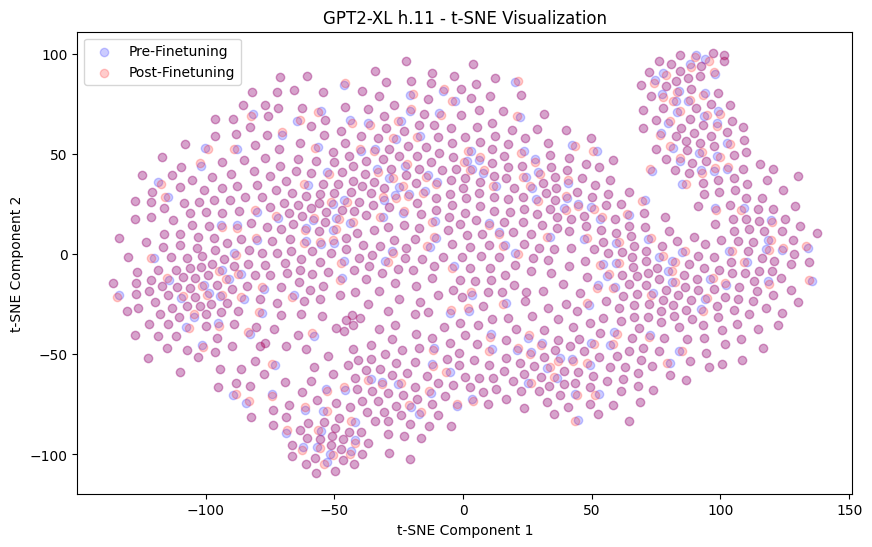

In [31]:
plot_activation_changes(activation1=gpt2xl_pre['h.11'], activation2=gpt2xl_post['h.11'], method='t-SNE', title='GPT2-XL h.11')

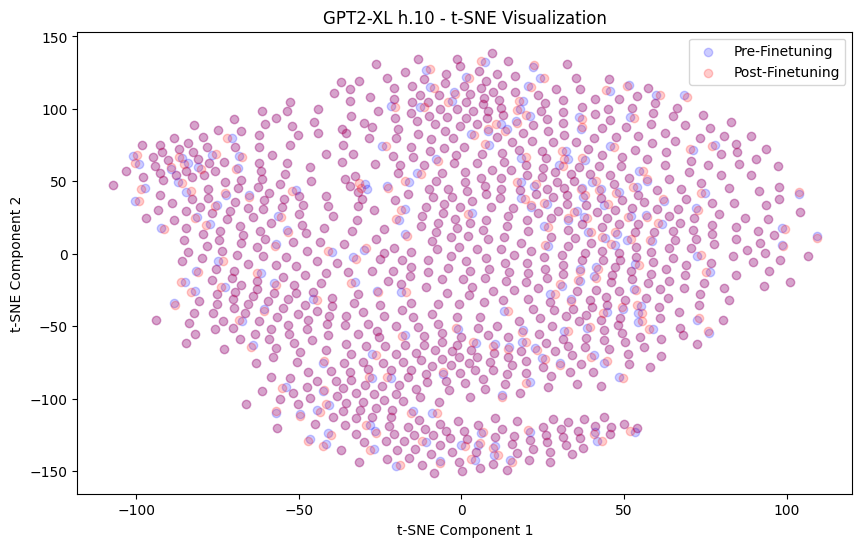

In [32]:
plot_activation_changes(activation1=gpt2xl_pre['h.10'], activation2=gpt2xl_post['h.10'], method='t-SNE', title='GPT2-XL h.10')

## cross-model

In [ ]:
# TODO


# find transformation & infer task rep

## cross-time

In [35]:
pre_ft_rep = gpt2xl_pre['h.11']
post_ft_rep = gpt2xl_post['h.11']
labels = datasets['train']['label'][:N['train']]

In [42]:
def linear_shift_loss(A, delta, lambda_x, lambda_x_tilde, labels):

    """
    Computes the loss for a batch of data.

    Args:
    A (torch.Tensor): The affine transformation matrix.
    delta (torch.Tensor): The rank-one update vector.
    lambda_x (torch.Tensor): Pre-finetuning activations (batch).
    lambda_x_tilde (torch.Tensor): Post-finetuning activations (batch).

    Returns:
    torch.Tensor: The computed loss.
    """

    # convert 0/1 labels to -1/1 labels; reshape from (N,) to (N,1)
    reshaped_labels = (labels + (labels - 1)).unsqueeze(-1)

    # apply affine transformation to lambda_x and shift by delta
    transformed = torch.mm(lambda_x, A) + reshaped_labels * delta  # delta shape (1, D)

    # Calculate the Frobenius norm of the difference, scaled by the number of samples
    recon_loss = torch.norm(transformed - lambda_x_tilde, p='fro') ** 2 / lambda_x.size(0)

    return recon_loss

In [44]:
# TODO (non-urgent): dataloader with shuffle; early stopping based on epoch loss

def optimize_Adelta(pre_ft_activations, post_ft_activations, labels, batch_size, lr=1e-3, tol=1e-5, max_iter=20000):

    """
    Optimizes A and delta parameters using the provided pre and post-finetuning activations.

    Args:
    pre_ft_activations (np.array): Pre-finetuning activations.
    post_ft_activations (np.array): Post-finetuning activations.
    dim (int): The dimensionality of each feature vector.
    batch_size (int): The size of each batch for optimization.
    lr (float): Learning rate for the optimizer.
    tol (float): Tolerance for convergence.
    max_iter (int): Maximum number of iterations.

    Returns:
    Tuple[np.array, np.array]: Optimized A and delta.
    """

    # get model dimension
    dim = pre_ft_activations.shape[1]
    
    # Initialize A and delta as torch tensors
    A = nn.Parameter(torch.eye(dim, requires_grad=True, device=device))
    delta = nn.Parameter(torch.zeros(1, dim, requires_grad=True, device=device))

    # Use the Adam optimizer
    optimizer = optim.Adam([A, delta], lr=lr)

    previous_loss = float('inf')
    for iteration in range(max_iter):

        for i in range(0, len(pre_ft_activations), batch_size):

            optimizer.zero_grad()

            batch_pre_ft = pre_ft_activations[i:i+batch_size].squeeze(1)
            batch_post_ft = post_ft_activations[i:i+batch_size].squeeze(1)
            batch_labels = labels[i:i+batch_size]
#             print(batch_pre_ft.shape)
#             print(batch_post_ft.shape)

            loss = linear_shift_loss(A, delta, batch_pre_ft, batch_post_ft, batch_labels)
            loss.backward()
            optimizer.step()

            current_loss = loss.item()
            if iteration % 50 == 0 and i == 0:  # Print the loss for the first batch every 10 iterations
                print(f"Iteration {iteration}, Loss: {current_loss:.6f}")
            if abs(previous_loss - current_loss) < tol:
                print("Convergence criterion met.")
                return A.detach(), delta.detach()
            previous_loss = current_loss

    print("Optimization finished.")
    return A.detach(), delta.detach()

In [45]:
A_opt, delta_opt = optimize_Adelta(pre_ft_activations=pre_ft_rep, post_ft_activations=post_ft_rep, labels=labels, batch_size=2000, lr=1e-3, tol=1e-5, max_iter=20000)

Iteration 0, Loss: 121.929504
Iteration 50, Loss: 6.667666
Iteration 100, Loss: 3.795356
Iteration 150, Loss: 3.176337
Iteration 200, Loss: 2.760151
Iteration 250, Loss: 2.448223
Iteration 300, Loss: 2.201952
Iteration 350, Loss: 2.000645
Iteration 400, Loss: 1.831920
Iteration 450, Loss: 1.687786
Iteration 500, Loss: 1.562797
Iteration 550, Loss: 1.453086
Iteration 600, Loss: 1.355813
Iteration 650, Loss: 1.268840
Iteration 700, Loss: 1.190519
Iteration 750, Loss: 1.119553
Iteration 800, Loss: 1.054905
Iteration 850, Loss: 0.995833
Iteration 900, Loss: 0.944652
Iteration 950, Loss: 0.907303
Iteration 1000, Loss: 0.845655
Iteration 1050, Loss: 0.802960
Iteration 1100, Loss: 0.766633
Iteration 1150, Loss: 0.731423
Iteration 1200, Loss: 0.701045
Iteration 1250, Loss: 1.534004
Iteration 1300, Loss: 0.931115
Iteration 1350, Loss: 0.952306
Iteration 1400, Loss: 0.894091
Iteration 1450, Loss: 0.960476
Iteration 1500, Loss: 1.036489
Iteration 1550, Loss: 1.300267
Iteration 1600, Loss: 1.44452

In [48]:
A_opt.shape

torch.Size([1600, 1600])

In [46]:
delta_opt

tensor([[-0.0008, -0.0003, -0.0024,  ..., -0.0024,  0.0007,  0.0018]],
       device='cuda:0')

### save

In [ ]:
# db = {
#     'A_opt': A_opt,
#     'delta_opt': delta_opt
# }

# with open(f"../results/transformation/temporal_signed_gpt2xl_ft=amazpola-gt_N={N['train']}.pickle", 'wb') as f:
#     pickle.dump(db, f)

In [51]:
with (open(f"../results/transformation/temporal_signed_gpt2xl_ft=amazpola-gt_N={10000}.pickle", "rb")) as f:
    db = pickle.load(f)

db

{'A_opt': tensor([[ 1.0150e+00,  1.6265e-03,  1.2608e-02,  ...,  2.3878e-03,
           5.2870e-03, -4.7890e-03],
         [-1.5942e-03,  1.0158e+00, -1.2098e-04,  ...,  5.8568e-03,
           6.8159e-03, -2.1452e-03],
         [ 1.0394e-02,  3.3850e-03,  1.0200e+00,  ..., -7.2959e-04,
           5.2230e-03, -5.0619e-03],
         ...,
         [ 1.2748e-03,  2.2789e-03,  1.0703e-02,  ...,  1.0228e+00,
           5.2250e-03, -3.9365e-03],
         [-1.3981e-02,  1.7400e-03, -4.8733e-03,  ...,  7.0545e-04,
           1.0194e+00, -4.4977e-03],
         [-1.0525e-02,  7.3040e-03,  5.8106e-03,  ...,  9.3395e-03,
          -6.5023e-04,  1.0196e+00]], device='cuda:0'),
 'delta_opt': tensor([[-5.5454e-04, -4.4035e-05, -7.6314e-04,  ...,  1.1511e-03,
          -4.2261e-04,  3.2231e-03]], device='cuda:0')}

### loss sanity check

In [58]:
# set model rep dimension
D = 768

In [59]:
A_test = torch.rand(D, D, device=device)
A_test

tensor([[0.8454, 0.3408, 0.7257,  ..., 0.1922, 0.3230, 0.3801],
        [0.7870, 0.4072, 0.6734,  ..., 0.9370, 0.0347, 0.5622],
        [0.2406, 0.1631, 0.1027,  ..., 0.3500, 0.7222, 0.6971],
        ...,
        [0.6927, 0.8460, 0.7912,  ..., 0.1799, 0.5827, 0.6067],
        [0.9617, 0.3252, 0.4637,  ..., 0.1648, 0.9512, 0.7483],
        [0.4929, 0.0519, 0.5195,  ..., 0.5585, 0.0525, 0.1418]],
       device='cuda:0')

In [65]:
delta_test = torch.ones(1, D, device=device)
delta_test.shape

torch.Size([1, 768])

In [63]:
labels_test = torch.randint(0, 2, (10000,), device=device)
labels_test

tensor([1, 0, 0,  ..., 1, 0, 0], device='cuda:0')

In [68]:
# sanity check with rand pre- and post-ft activations
activation_pre = torch.rand(10000, D, device=device)
activation_post = torch.mm(activation_pre, A_test) + (labels_test + (labels_test - 1)).unsqueeze(-1) * delta_test

In [69]:
activation_pre

tensor([[0.8896, 0.1563, 0.2371,  ..., 0.7455, 0.4702, 0.6767],
        [0.4114, 0.5977, 0.9330,  ..., 0.6033, 0.7133, 0.0798],
        [0.3303, 0.1095, 0.0079,  ..., 0.9362, 0.3507, 0.2367],
        ...,
        [0.6645, 0.2325, 0.7324,  ..., 0.8525, 0.3268, 0.3042],
        [0.6750, 0.5569, 0.7080,  ..., 0.1567, 0.8694, 0.1064],
        [0.9829, 0.3157, 0.5046,  ..., 0.8000, 0.9893, 0.9744]],
       device='cuda:0')

In [70]:
activation_post

tensor([[193.8935, 203.0139, 192.9750,  ..., 190.2747, 199.0667, 206.8257],
        [193.3691, 201.9770, 191.1656,  ..., 182.9456, 196.8861, 198.0956],
        [189.2366, 200.9785, 187.5216,  ..., 184.9357, 190.4426, 199.4775],
        ...,
        [192.3136, 203.8072, 190.7416,  ..., 187.9311, 197.1982, 206.9719],
        [184.4500, 192.9791, 177.9782,  ..., 175.8113, 189.4777, 189.5950],
        [189.0799, 201.6201, 186.5544,  ..., 183.5273, 191.0172, 204.0677]],
       device='cuda:0')

In [72]:
A_test_opt, delta_test_opt = optimize_Adelta(pre_ft_activations=activation_pre, post_ft_activations=activation_post, labels=labels_test, batch_size=2000, lr=1e-3, tol=1e-5, max_iter=20000)

Iteration 0, Loss: 28232544.000000
Iteration 50, Loss: 8783695.000000
Iteration 100, Loss: 1897138.375000
Iteration 150, Loss: 262374.468750
Iteration 200, Loss: 25207.306641
Iteration 250, Loss: 5277.470215
Iteration 300, Loss: 4276.519531
Iteration 350, Loss: 4195.062012
Iteration 400, Loss: 4152.375977
Iteration 450, Loss: 4121.506348
Iteration 500, Loss: 4097.995605
Iteration 550, Loss: 4078.346680
Iteration 600, Loss: 4059.917969
Iteration 650, Loss: 4040.908203
Iteration 700, Loss: 4020.185547
Iteration 750, Loss: 3997.049805
Iteration 800, Loss: 3971.020508
Iteration 850, Loss: 3941.700684
Iteration 900, Loss: 3908.699707
Iteration 950, Loss: 3871.608398
Iteration 1000, Loss: 3829.984375
Iteration 1050, Loss: 3783.352783
Iteration 1100, Loss: 3731.205078
Iteration 1150, Loss: 3673.006836
Iteration 1200, Loss: 3608.199219
Iteration 1250, Loss: 3536.208740
Iteration 1300, Loss: 3456.458252
Iteration 1350, Loss: 3368.384521
Iteration 1400, Loss: 3271.455322
Iteration 1450, Loss: 31

In [73]:
A_test_opt

tensor([[0.8463, 0.3407, 0.7251,  ..., 0.1916, 0.3226, 0.3797],
        [0.7865, 0.4104, 0.6723,  ..., 0.9369, 0.0353, 0.5613],
        [0.2406, 0.1634, 0.1042,  ..., 0.3508, 0.7206, 0.6969],
        ...,
        [0.6934, 0.8462, 0.7914,  ..., 0.1822, 0.5823, 0.6075],
        [0.9613, 0.3244, 0.4639,  ..., 0.1651, 0.9518, 0.7464],
        [0.4927, 0.0532, 0.5195,  ..., 0.5588, 0.0536, 0.1460]],
       device='cuda:0')

In [74]:
delta_test_opt

tensor([[1.0000, 1.0001, 0.9999, 0.9999, 1.0000, 1.0000, 1.0001, 1.0000, 1.0001,
         1.0000, 0.9998, 0.9999, 0.9999, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 0.9999, 1.0001, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         0.9999, 1.0000, 1.0001, 1.0000, 1.0000, 0.9999, 1.0001, 1.0000, 1.0000,
         1.0000, 1.0001, 1.0000, 1.0000, 1.0001, 1.0000, 1.0000, 1.0000, 0.9999,
         1.0001, 1.0000, 1.0000, 1.0000, 1.0001, 1.0001, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0001, 1.0001,
         0.9999, 1.0000, 1.0000, 0.9999, 1.0000, 0.9999, 1.0000, 1.0000, 0.9999,
         0.9999, 1.0002, 0.9999, 1.0000, 1.0001, 1.0000, 1.0000, 0.9999, 1.0000,
         1.0000, 1.0000, 1.0001, 1.0000, 1.0001, 1.0001, 1.0000, 1.0000, 1.0001,
         1.0000, 0.9998, 1.0000, 1.0001, 1.0000, 1.0001, 1.0000, 0.9999, 1.0000,
         1.0000, 1.0000, 0.9999, 1.0001, 1.0001, 1.0000, 0.9999, 1.0002, 1.0000,
         1.0000, 0.9999, 1.0

In [76]:
cosine_similarity(delta_test_opt.cpu(), delta_test.cpu())

array([[0.99999994]], dtype=float32)

### identifiability analysis

In [54]:
# corr between delta_opt found with 1k vs 10k samples
cosine_similarity(delta_opt.cpu(), db['delta_opt'].cpu())

array([[0.121593]], dtype=float32)

In [ ]:
# TODO: run opt multiple times with different samples and seeds 


## cross-model

In [ ]:
# TODO: fine affine transformation with dim reduction


# gt task rep through linear probing

In [ ]:
def linear_probe(activations, labels):

    X = np.array([(np.array([1]) + act.detach().cpu().numpy()).mean(axis=0) for act in activations])
    y = np.array(labels)

    print(X.shape)
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the linear classifier
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    return clf

In [ ]:
clf = linear_probe(gpt2_post['h.11'], labels)

# compare inferred task rep against gt